**Note**
+ Il file di ieri (Lezione5): machine_translation_Huggingface, è stato modificato dal prof. e caricato su Paperspace per eseguire l'addestramento.
+ stamattina si sta ancora allendando

**Estensioni** Utili (Strati appositi, dataset, modelli)
+ keras per ComputerVision
+ keras per NLP

# Attention

vedi *appunti*

+ https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention
+ additive, normal, multi_head attention

In [3]:
import tensorflow as tf
import keras
from keras.layers import Attention

In [4]:
attention = Attention()

In [5]:
query = tf.random.normal(shape = [32, 10, 128]) # batch_size x numero di query x dimensione query

In [6]:
value = tf.random.normal(shape= [32, 20, 128]) # possono esserci più valori che query

In [10]:
output, attention_scores = attention([query, value], return_attention_scores=True) # restituisce la matrice di attenzione

In [11]:
output.shape # numero di query e quindi di risposte x dimensione valori

TensorShape([32, 10, 128])

In [13]:
attention_scores.shape # L x M = per ogni query ho M chiavi (scores della matrice di affinità)

TensorShape([32, 10, 20])

In [14]:
tf.reduce_sum(attention_scores[0], axis = 1) # per ogni query, i pesi sommati fanno 1, normalizzati (affinità come probabilità)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.        , 0.99999994, 1.0000001 , 1.0000001 , 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 1.        ],
      dtype=float32)>

In [ ]:
vedi file "machine translation attention"

# Image Segmentation
Esempio di Image Segmentation (da: Deep Learning with Python, Chollet)
+ è classificazione pixel x pixel (una classe a ogni pixel)
+ ex. ambito medico

## Dataset

In [ ]:
# Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/
+ https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
+ https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

vedi notebook del prof:
https://colab.research.google.com/drive/1Hs3KdR652avrxtlijtdVjC0bZPVwOTUI?usp=sharing

In [15]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

--2023-09-21 11:18:33--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98, 198.41.0.4, 199.9.14.201, ...
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-09-21 11:18:33--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  1.51MB/s    in 5m 9s   

2023-09-21 11:23:42 (2.45 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2023-09-21 11:23:43--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98, 

In [22]:
! tar -xf annotations.tar.gz
! tar -xf images.tar.gz

In [8]:
# Come sono fatte le immagini?
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [9]:
img = Image.open("images/Abyssinian_1.jpg") # PIL x decodificare jpeg
img_array = np.array(img)

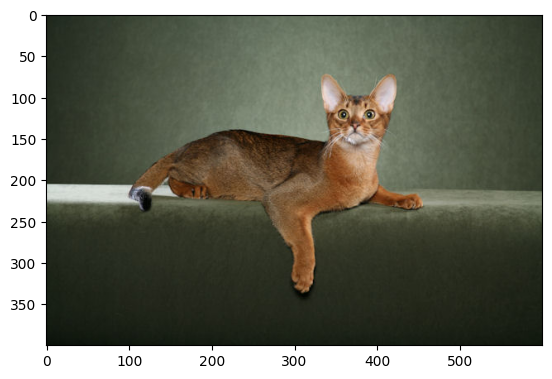

In [10]:
# print(img_array)
plt.imshow(img_array)

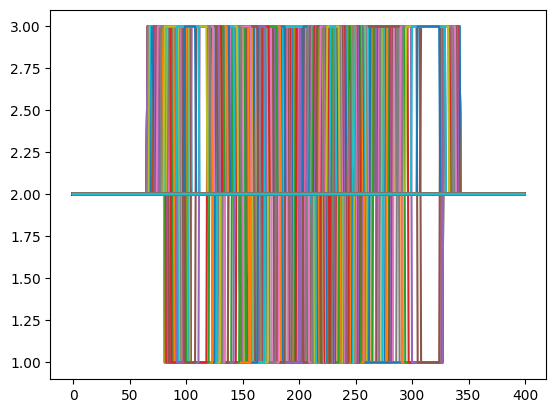

In [11]:
img_mask = Image.open("annotations/trimaps/Abyssinian_1.png") # PIL x decodificare jpeg
img_mask_array = np.array(img_mask)
plt.plot(img_mask_array)

In [12]:
img_mask_array.shape # è in grayscale

(400, 600)

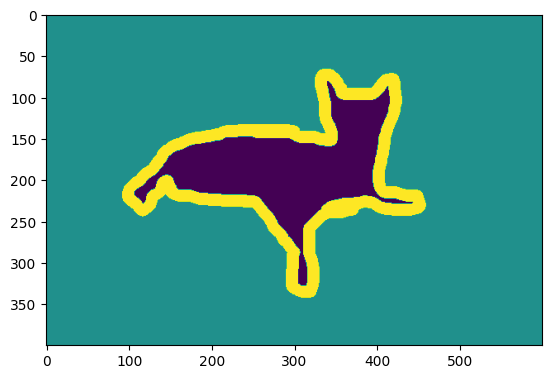

In [13]:
plt.imshow(img_mask_array.reshape(*img_mask_array.shape))

In [14]:
np.unique(img_mask_array)

array([1, 2, 3], dtype=uint8)

In [ ]:
img_mask_array[200,300] # becca il pixel dentro al gatto, quindi 1 è gatto
img_mask_array[150,300]

**Codifica**
1. gatto
2. sfondo
3. bordo

## Dataset Generator
Carica dinamicamente Image e Label

In [2]:
import os
from pathlib import Path #  non usato
import tensorflow as tf

2023-09-21 15:12:07.351989: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 15:12:07.939942: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 15:12:07.946030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 15:12:10.511939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from tensorflow.data import Dataset

In [16]:
# Prende images e label dai file, come np.array, li ritorna con yield
def data_generator():
    # for che Scorre su ogni immagine jpeg
    for filepath in [f for f in os.listdir("images") if f.endswith(".jpg")]:
        # Immagine
        img = Image.open("images/"+filepath)
        img = img.resize((200, 200))
        img_array = np.array(img).astype(np.float32) / 255. # img come array e normalizzate

        if img_array.ndim != 3: #alcune img lack una dimensione e da errore
            img_array = np.stack([img_array, img_array, img_array], axis=-1) # stack collega con un nuovo asse (cerca)
        elif img_array.shape[-1] > 3: # se c'è il canale alpha
            img_array = img_array[..., :3] # prende tutte le dimensioni prima dell'ultima. l'ultima solo 0,1,2 non il canale alpha
    
        # Maschera (label)
        mask = Image.open(f"annotations/trimaps/{filepath[:-4]}.png") #oppure split al .
        mask = mask.resize((200, 200))
        mask_array = np.array(mask).astype(np.int32) -1 # perché label sono 1,2,3 e noi vogliamo 0,1,2

        yield img_array, mask_array
        

In [17]:
# Crea un dataset usando la classe di TF
dataset = Dataset.from_generator(
                      data_generator,
                      output_signature = ( # una lista di tensorflow spec (dico come saranno fatti i tensori)
                          tf.TensorSpec(shape=(200, 200, 3), dtype = tf.float32), # image
                          tf.TensorSpec(shape=(200, 200), dtype = tf.int32) # mask
                      )
)

In [18]:
dataset = dataset.shuffle(buffer_size = 1_000).batch(4) # con 16 exceeded RAM by 10%

In [19]:
next(iter(dataset)) # se ci fosse un file corrotto metti try except pass nel dataset_generator

2023-09-21 15:13:19.294119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 404 of 1000
2023-09-21 15:13:29.295219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 814 of 1000
2023-09-21 15:13:34.073957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


(<tf.Tensor: shape=(4, 200, 200, 3), dtype=float32, numpy=
 array([[[[0.1254902 , 0.20392157, 0.08627451],
          [0.09019608, 0.16470589, 0.0627451 ],
          [0.09411765, 0.16862746, 0.06666667],
          ...,
          [0.13333334, 0.17254902, 0.11372549],
          [0.04705882, 0.10980392, 0.03529412],
          [0.07058824, 0.13333334, 0.03921569]],
 
         [[0.09019608, 0.13725491, 0.05490196],
          [0.10196079, 0.16470589, 0.07843138],
          [0.12941177, 0.21176471, 0.08627451],
          ...,
          [0.13725491, 0.16470589, 0.12156863],
          [0.04313726, 0.08235294, 0.02352941],
          [0.07843138, 0.1254902 , 0.05490196]],
 
         [[0.07058824, 0.15294118, 0.0627451 ],
          [0.06666667, 0.14901961, 0.0627451 ],
          [0.12156863, 0.1764706 , 0.07450981],
          ...,
          [0.07450981, 0.11372549, 0.08627451],
          [0.07058824, 0.1254902 , 0.0627451 ],
          [0.13333334, 0.20784314, 0.11764706]],
 
         ...,
 
       

## Architettura Fully Convolutional x Segmentazione

+ vedi appunti
+ Chollet pg
+ Dive into DeepLearning

  
Note: altra rete x segm. Unet

In [20]:
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.activations import softmax
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

In [21]:
# fully convo. neural network
fcnn = Sequential(
    [
        Conv2D(filters = 64, kernel_size=3, strides = 2, padding="same", activation="relu"), # padding same è più comodo per gestire le dimensioni
        Conv2D(filters = 64, kernel_size=3, padding="same", activation="relu"),              # stride = 1
        Conv2D(filters = 128, kernel_size=3, strides = 2, padding="same", activation="relu"),
        Conv2D(filters = 128, kernel_size=3, padding="same", activation="relu"),
        Conv2D(filters = 256, kernel_size=3, strides = 2, padding="same", activation="relu"),
        Conv2D(filters = 256, kernel_size=3, padding="same", activation="relu"),
        # in totale 3 dimezzamenti: 200x200 a 25x25

        # rete speculare
        Conv2DTranspose(filters = 256, kernel_size=3, padding="same", activation="relu"),        
        Conv2DTranspose(filters = 128, kernel_size=3, strides = 2, padding="same", activation="relu"), # stride = 2 fa up-sampling
        Conv2DTranspose(filters = 128, kernel_size=3, padding="same", activation="relu"),
        Conv2DTranspose(filters = 64, kernel_size=3, strides = 2, padding="same", activation="relu"),
        Conv2DTranspose(filters = 64, kernel_size=3, padding="same", activation="relu"),
        Conv2DTranspose(filters = 256, kernel_size=3, strides = 2, padding="same", activation="relu"),

        # ultimo strato: 3 classi allora 3 filtri
        Conv2D(filters = 3, kernel_size=3, padding="same", activation="softmax") # la softmax va applicata sull'asse della profondità
        # batch_size x w x h x depth (softmax su asse depth)
        # il layer conv2D lo fa in automatico
        # ma se volessi farlo noi:
        # Conv2D(filters = 3, kernel_size=3, padding="same", activation= softmax(x, axis = -1)) # x?
    ]
)

In [22]:
fcnn.compile(
    optimizer = Adam(),
    loss = SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [23]:
fcnn.fit(x = dataset, epochs = 1) # interrupted by me

2023-09-21 15:13:46.960090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 448 of 1000
2023-09-21 15:13:56.964623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 888 of 1000
2023-09-21 15:13:59.519293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


    302/Unknown - 697s 2s/step - loss: 0.8994 - accuracy: 0.5893

KeyboardInterrupt: 

In [26]:
fcnn.save_weights("weights_302/461.h5") # not working

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'weights_302/461.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

**Nota**
+ callback o tensorboard per vedere cosa sta facendo
+ metodi per cambiare il learning rate durante il training (scheduler)
di solito LR parte piccolo (warm up), poi aumenta, poi torna a diminuire

Cerca come salvare il modello e il training per riprenderlo dopo

### Inference su Immagine presa da internet

In [27]:
img_array = np.array(
    Image.open("e_cat.jpg").resize((200,200))
).astype(np.float32) / 255.

In [28]:
img_array = np.expand_dims(img_array, 0)

In [30]:
preds = fcnn(img_array)

In [31]:
preds[0, 0, 0, :] # preds sono le predizioni?

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.27242646, 0.55718666, 0.17038687], dtype=float32)>

In [46]:
preds.shape, preds[0,0]

((200, 200, 3), array([0.27242646, 0.55718666, 0.17038687], dtype=float32))

In [32]:
preds = np.squeeze(preds) # per togliere dim del batch
output = np.argmax(preds, axis = -1)

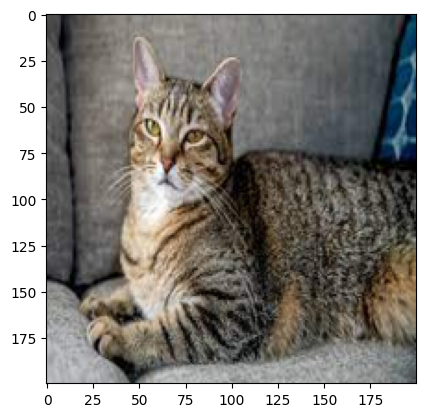

In [33]:
plt.imshow(img_array[0])

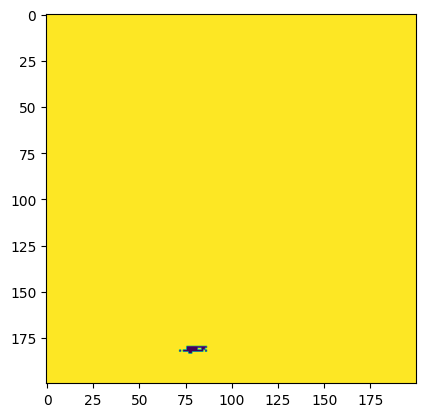

In [35]:
plt.imshow(output) # stampa la maschera

# ResNet

+ vedi Dive Into Deep Learning: https://d2l.ai/chapter_convolutional-modern/resnet.html
+ vedi appunti e resnet.ipynb del prof.

In [ ]:
import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense, Lambda
from keras.models import Model
from keras import Sequential
from keras.utils import plot_model

import numpy as np

In [ ]:
#  Residual block functional

class Residual(Model):
    def __init__(self, num_channels_out, stride=1, conv1d=False):
        super().__init__()
        self.conv1 = Conv2D(filters=num_channels_out, kernel_size=3, strides=stride, padding="same")
        self.conv2 = Conv2D(filters=num_channels_out, kernel_size=3, padding="same")
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

        self.conv3 = None
        if conv1d:
            self.conv3 = tf.keras.layers.Conv2D(num_channels_out, kernel_size=1,
                                                strides=stride)

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X # skip connection
        return tf.keras.activations.relu(Y)

In [ ]:
x = tf.random.normal(shape=[32, 120, 80, 64])
Residual(num_channels_out=32, stride=2, conv1d=True)(x)

In [ ]:
def get_block(num_residuals, num_channels_out, is_first_block):
    block = Sequential(
        [Residual(num_channels_out, 1 if is_first_block else 2, not is_first_block)]
    )
    for _ in range(num_residuals-1):
        block.add(Residual(num_channels_out))

    return block

In [ ]:
resnet_18 = Sequential([
    Lambda(lambda x: tf.expand_dims(x, -1)),
    Lambda(lambda x: tf.image.resize(x, [96, 96])),
    Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=[28*4, 28*4, 1]),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
    get_block(2, 64, True),
    get_block(2, 128, False),
    get_block(2, 256, False),
    GlobalAveragePooling2D(), # al posto del classico Flatten
    Dense(10, "softmax")
])

In [ ]:
plot_model(resnet_18, expand_nested=True )

In [ ]:
from keras.datasets.mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()

x_train = (x_train / 255).astype(np.float32)
x_test = (x_test / 255).astype(np.float32)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

resnet_18.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])

resnet_18.fit(x=x_train, y=y_train, epochs=10, shuffle=True, validation_split=0.2)

tf.data.Dataset.from_tensor_slices(x_train).map()